In [1]:
import os, sys
sys.path.append("motion_generation")
sys.path.append("rig_agnostic_encoding/functions")
sys.path.append("rig_agnostic_encoding/models")

from motion_generation.MoE import MoE
from motion_generation.GRU import GRU
from motion_generation.LSTM import LSTM
from motion_generation.MotionGeneration import MotionGenerationModel
from motion_generation.MotionGeneration_v2 import MotionGenerationModel as MotionGenerationModel_v2
from motion_generation.MotionGenerationRNN import MotionGenerationModelRNN
from motion_generation.MotionGenerationBatch import MotionGenerationModelBatch
from rig_agnostic_encoding.models.MLP import MLP
from rig_agnostic_encoding.models.VAE import VAE
from rig_agnostic_encoding.models.DEC import DEC
from rig_agnostic_encoding.models.VaDE import VaDE
import rig_agnostic_encoding.models.MLP_MIX
from rig_agnostic_encoding.models.MLP_MIX import MLP_MIX
from rig_agnostic_encoding.models.RBF import RBF

from rig_agnostic_encoding.functions.DataProcessingFunctions import clean_checkpoints
from GlobalSettings import MODEL_PATH

import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import func as F
import _pickle as pickle
import json as js
import ray
import importlib



In [2]:
config = {
    "hidden_dim": 512,
    "k": 512,
    "lr": 1e-4,
    "batch_size": 32,
    "keep_prob": .2,
    "loss_fn":torch.nn.functional.mse_loss,
    "optimizer":torch.optim.AdamW,
    "scheduler":torch.optim.lr_scheduler.StepLR,
    "scheduler_param": {"step_size":80, "gamma":.7},
    "basis_func":"gaussian",
    "n_centroid":128,
    "k_experts": 4,
    "gate_size": 64,
    "g_hidden_dim": 256,
    "num_layers": 4,
    "autoregress_prob":0,
    "autoregress_inc":.2,
    "autoregress_ep":10,
    "autoregress_max_prob":.5,
    "cost_hidden_dim":128,
    "seq_len":13,
    "device":"cuda"
    }

In [8]:
MAX_FILES = -1
data_path = "/home/nuoc/Documents/MEX/data/Dataset_R1_One_1"
file_paths = []
for dname, dirs, files in os.walk(data_path):
    for i, file in enumerate(files):
        file_paths.append(os.path.join(dname, file))
        if MAX_FILES > 0 and i >= MAX_FILES:
            break

In [9]:
pose_features = ["pos", "rotMat2", "velocity"]
clips = []
feature_dims = {}

In [10]:
data = F.process_data_multithread(file_paths, pose_features, level=0)
# data2 = F.process_data_multithread(file_paths, pose_features, level=0)

2021-05-04 15:22:16,424	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


In [11]:
feature_dims = data[0][1]
# feature_dims2 = data2[0][1]
clips = [np.copy(d[0]) for d in data]
# clips2 = [np.copy(d[0]) for d in data2]

In [12]:
pose_dim = sum([feature_dims[feature] for feature in pose_features])
# pose_dim2 = sum([feature_dims2[feature] for feature in pose_features])
print(pose_dim)
# print(pose_dim2)



372


In [13]:
x_tensors = torch.stack([F.normaliseT(torch.from_numpy(clip[:-1])).float() for clip in clips])
# x_tensors2 = torch.stack([F.normaliseT(torch.from_numpy(clip[:-1])).float() for clip in clips2])

y_tensors = torch.stack([torch.from_numpy(clip[1:]).float() for clip in clips])
# y_tensors2 = torch.stack([F.normaliseT(torch.from_numpy(clip[1:])).float() for clip in clips2])

# y_tensorsO= torch.stack([torch.from_numpy(clip[1:]).float() for clip in clips])
# y_tensorsO2 = torch.stack([torch.from_numpy(clip[1:]).float() for clip in clips2])

# x_tensors = torch.cat((x_tensors, x_tensors2), dim=2)
# y_tensors = torch.cat((y_tensors, y_tensors2), dim=2)

dataset = TensorDataset(x_tensors,y_tensors)
N = len(x_tensors)

train_ratio = int(.7*N)
val_ratio = int((N-train_ratio) / 2.0)
test_ratio = N - train_ratio - val_ratio
train_set, val_set, test_set = random_split(dataset, [train_ratio, val_ratio, test_ratio], generator=torch.Generator().manual_seed(2021))
print(len(train_set), len(val_set), len(test_set))

168 36 36


In [3]:
dataset_name = "R1_Pose_data_pos_rotMat2_vel_single"

In [15]:
# data = {"data":[train_set, val_set, test_set], "feature_dims":feature_dims, "pose_dims":[pose_dim, pose_dim2]}
data = {"data":[train_set, val_set, test_set], "feature_dims":feature_dims, "pose_dims":pose_dim}
F.save(data, dataset_name, "/home/nuoc/Documents/MEX/data")

In [4]:
obj = F.load("/home/nuoc/Documents/MEX/data/"+dataset_name+".pbz2")
train_set, val_set, test_set = obj["data"]
feature_dims = obj["feature_dims"]
x_tensors, y_tensors2 = obj["original"]
pose_dim, pose_dim2 = obj["pose_dims"]


KeyError: 'original'

In [ ]:
# pose_dim = x_tensors.shape[-1]
print(len(train_set), train_set[0][0].shape)
print(len(val_set), val_set[0][0].shape)
print(len(test_set), test_set[0][0].shape)

In [ ]:
model_name = "MLP_MLP_AE_noNorm"

In [21]:
model = MLP_MIX(config=config, input_dims=[pose_dim], name=model_name,
                train_set=train_set, val_set=val_set, test_set=test_set)

In [5]:
model = MLP_MIX.load_checkpoint("/home/nuoc/Documents/MEX/models/version_0.2/MLP_MLP_AE_noNorm/0.1271349936723709.512.pbz2")

In [22]:
MAX_EPOCHS = 300

checkpoint_callback = ModelCheckpoint(monitor="avg_val_loss", save_top_k=3)
earlystopping = EarlyStopping(monitor="avg_val_loss", patience=20)
logger=TensorBoardLogger(save_dir="logs/", name=model_name, version="0.1")

trainer = pl.Trainer(
    default_root_dir="/home/nuoc/Documents/MEX/src/version_0.2/checkpoints",
    gpus=1, precision=16,
    callbacks=[earlystopping],
    min_epochs=20,
    logger=logger,
    max_epochs=MAX_EPOCHS,
    stochastic_weight_avg=True
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | cluster_model | Sequential | 262 K 
---------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)


Restored states from the checkpoint file at /home/nuoc/Documents/MEX/src/version_0.2/lr_find_temp_model.ckpt
<ipython-input-10-5a2096fcef99>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



0.0010964781961431851


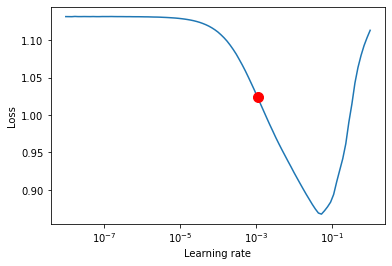

In [10]:
trainer2 = pl.Trainer(gpus=1)
lr_finder = trainer2.tuner.lr_find(model)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
model.hparams.lr = new_lr
model.learning_rate = new_lr


In [23]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | cluster_model | Sequential | 262 K 
---------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)


/home/nuoc/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Swapping lr_scheduler <torch.optim.lr_scheduler.StepLR object at 0x7f6ceb618340> for <torch.optim.swa_utils.SWALR object at 0x7f6ceb948130>
  warnings.warn(*args, **kwargs)


1

In [24]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': 0.12942981719970703, 'test_loss': 0.15024323761463165}
--------------------------------------------------------------------------------


[{'test_loss': 0.15024323761463165, 'ptl/test_loss': 0.12942981719970703}]

In [25]:
clean_checkpoints(path=os.path.join(MODEL_PATH,model_name))

In [6]:
n = 5
idx = np.random.randint(0, len(test_set), n)
original = []
generated = []

In [32]:
# print(y_tensors2.shape)
print(x_tensors1.shape)
print(y_tensorsO.shape)

torch.Size([240, 299, 72])
torch.Size([240, 299, 72])


In [8]:
with torch.no_grad():
    model.eval()
    model.cuda()
    # for i in range(1):
    x = torch.stack([test_set[i][0] for i in idx]).cuda()
    y = torch.stack([test_set[i][1] for i in idx])
    shape = x.shape
    x = x.view(-1, shape[-1])
    g_frames = []
    out = model.active_models[0](x).view(shape)
    generated = out

In [10]:
print(y.size())
print(generated.size())

torch.Size([5, 299, 372])
torch.Size([5, 299, 372])


In [12]:
toPosDim = feature_dims["pos"]
toRotDim = toPosDim + feature_dims["rotMat2"]
# toPosDim = 93
# toRotDim = toPosDim + 186

gPos = generated[:, :, :toPosDim].to("cpu")
gRot = generated[:, :, toPosDim:toRotDim].to("cpu")

oPos = y[:, :, :toPosDim].to("cpu")
oRot = y[:, :, toPosDim:toRotDim].to("cpu")

print(gPos.shape, gRot.shape)
print(oPos.shape, oRot.shape)


torch.Size([5, 299, 93]) torch.Size([5, 299, 186])
torch.Size([5, 299, 93]) torch.Size([5, 299, 186])


In [13]:
clip_length = gPos.shape[1]
gPos_r = gPos.reshape((n, clip_length, -1, 3))
gRot_r = gRot.reshape((n, clip_length, -1, 3, 2))
oPos_r = oPos.reshape((n, clip_length, -1, 3))
oRot_r = oRot.reshape((n, clip_length, -1, 3, 2))

print("Pos loss: ", torch.nn.functional.mse_loss(gPos_r, oPos_r))
print("Rot loss: ", torch.nn.functional.mse_loss(gRot_r, oRot_r))

Pos loss:  tensor(0.5522)
Rot loss:  tensor(0.7078)


In [14]:
template = js.load(open("/home/nuoc/.config/unity3d/DefaultCompany/Procedural Animation/TestAll_1_R1_One_1/False_2_0.json"))

In [17]:
def insert_pos(positions, rotations, name="Replay"):
    shape = positions.shape
    for c in range(shape[0]):
        for f in range(shape[1]):
            for j in range(shape[2]):
                template["frames"][f]["joints"][j]["position"]["x"] = positions[c, f, j,0].item()
                template["frames"][f]["joints"][j]["position"]["y"] = positions[c, f, j,1].item()
                template["frames"][f]["joints"][j]["position"]["z"] = positions[c, f, j,2].item()

                k=0
                for r, cell in enumerate(["x", "y", "z"]):
                    for col, column in enumerate(["c0", "c1"]):
                        template["frames"][f]["joints"][j]["rotMat"][column][cell] = rotations[c, f, j, r,col].item()
                        k+=1
        with open("{}_{}.json".format(name, c), "w") as f:
            js.dump(template, f)
I = 4
insert_pos(oPos_r, oRot_r, "/home/nuoc/.config/unity3d/DefaultCompany/Procedural Animation/TestAll_1_R1_Two_1/Replay_MLP_AE_original"+str(I))
insert_pos(gPos_r, gRot_r, "/home/nuoc/.config/unity3d/DefaultCompany/Procedural Animation/TestAll_1_R1_Two_1/Replay_MLP_AE_generated"+str(I))
